In [74]:
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import elementwise_grad

import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
import scipy
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

np.random.seed(123) # set the seed

In [84]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    ''' A numpy implementation for logistic regression models. To be used for BBVI.
    '''
    
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes
        self.D = len(slopes) + 1
    def predict(self, x):
        x = x.T
        y = sigmoid(np.matmul(self.slopes, x) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        x = x.T
        output = sigmoid(np.matmul(self.slopes, x) + self.intercept)
        return np.array([1-output, output]).T

def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.5
        linewidths= 0.1
        
    i = 0
    
    YY = np.zeros(models[0].predict(xx).shape).reshape((n, n))
    for model in models:

#         yy = model.predict_proba(xx)
        yy = model.predict_proba(xx)[:,1]
        
        # plot decision boundary
        yy = yy.reshape((n, n))
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        # calculate accumulated dicision surface in the for loop
        YY += yy  

    # Plot decision surface
    YY /= len(models)
    if shaded:
        if len(models)==1:
            vmin=0
            vmax=1
            levels = np.linspace(vmin, vmax, 20+1)
            img = ax.contourf(x1, x2, YY, cmap='bwr',levels=levels, alpha = .3, vmin=vmin, vmax=vmax)
            fig.colorbar(img)
        else:
            vmin=0
            vmax=1
            levels = np.linspace(vmin, vmax, 20+1)
            img = ax.contourf(x1, x2, YY, cmap='bwr',levels=levels, alpha = 50./len(models), vmin=vmin, vmax=vmax)
            fig.colorbar(img)

        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

In [105]:
# Generate a toy dataset for classification

samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

# Define test data points
test_points = [(1.5, 1.5), (0, 0), (4, 4), (4, -4)]

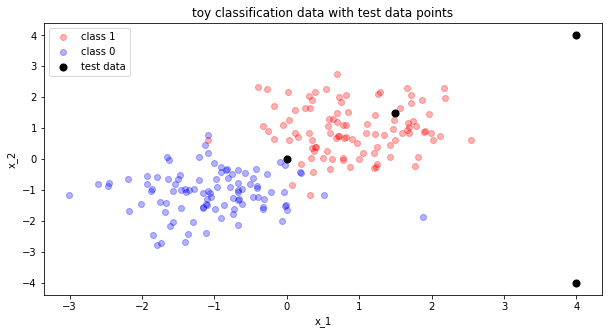

In [106]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()


In [107]:
# train a logistic regression model on the data
poly_degree = 1

poly = PolynomialFeatures(poly_degree,include_bias=False)
x_poly = poly.fit_transform(x)
model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1);
model.fit(x_poly,y)

for c,test_point in enumerate(test_points):
    test_point = np.array(test_point).reshape(1,-1)
    test_point = poly.fit_transform(test_point)
    print(f' p({test_point} is class 0) = {(model.predict_proba(test_point.reshape(1,-1)))[0][0]} p({test_point} is class 1) = {(model.predict_proba(test_point.reshape(1,-1)))[0][1]}')
#     print(model.predict(test_point.reshape(1,-1)))

 p([[1.5 1.5]] is class 0) = 0.00020038654844944936 p([[1.5 1.5]] is class 1) = 0.9997996134515506
 p([[0. 0.]] is class 0) = 0.4130513974617598 p([[0. 0.]] is class 1) = 0.5869486025382402
 p([[4. 4.]] is class 0) = 2.4710122836779647e-10 p([[4. 4.]] is class 1) = 0.9999999997528988
 p([[ 4. -4.]] is class 0) = 0.4974616476056951 p([[ 4. -4.]] is class 1) = 0.5025383523943049


In [88]:
# HMC 

def leap_frog(position_init, momentum_init, step_size, leapfrog_steps, potential_energy, kinetic_energy):        # initialize position
        position = position_init
        # initialize momentum
        momentum = momentum_init

        # compute the gradient of potential energy
        potential_energy_grad = elementwise_grad(potential_energy)

        # compute the gradient of kinetic energy
        kinetic_energy_grad = elementwise_grad(kinetic_energy)

        # full leap frog steps
        for _ in range(leapfrog_steps - 1):
            # half step update of momentum
            momentum = momentum - step_size * 0.5 * potential_energy_grad(position)

            # full step update of position
            position = position + step_size * kinetic_energy_grad(momentum)

            # half step update of momentum
            momentum = momentum - step_size * 0.5 * potential_energy_grad(position)

            assert not np.any(np.isnan(position))
            assert not np.any(np.isnan(momentum))

        # Reverse momentum
        momentum = -momentum
        return position, momentum

def hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler):

        ### Define total energy
        total_energy = lambda q, p: potential_energy(q) + kinetic_energy(p)

        ### Sample momentum
        # Make sure that the distribution from which you sample the momentum matches 
        # with your kinetic energy function
        momentum_current = momentum_sampler(1) 

        ### Simulate Hamiltonian dynamics using Leap Frog
        position_proposal, momentum_proposal = leap_frog(position_current.copy(), momentum_current.copy(), step_size, leapfrog_steps, potential_energy, kinetic_energy)

        # compute total energy in current position and proposal position
        current_total_energy = total_energy(position_current, momentum_current)
        proposal_total_energy = total_energy(position_proposal, momentum_proposal)

        ### Metropolis Hastings Step
        # comute accept probability
        accept_prob = min(1,np.exp(current_total_energy - proposal_total_energy))

        # accept proposal with accept probability
        if np.random.rand() < accept_prob:
            accept = 1
            position_current = np.copy(position_proposal)
            momentum_current = np.copy(momentum_proposal)
        else:
            accept = 0
            
        return position_current, momentum_current, accept



In [89]:
x_1 = np.append(np.ones([x.shape[0],1]),x,axis = 1) # add a column of ones
y = np.array([0] * 100 + [1] * 100)

### Setting up the energy functions for HMC
potential_energy = lambda q: np.sum(0.5*0.1 * np.power(q,2)) - np.dot(y,np.log(1e-10+ sigmoid(np.matmul(x_1,q))))- np.dot((1-y),np.log(1e-10+1 -sigmoid(np.matmul(x_1,q))))
kinetic_energy = lambda p: np.sum(0.5*np.power(p,2))
momentum_sampler = lambda n: np.random.normal(0,1,size = x_1.shape[1])

### Setting up hyperparameters of HMC
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = np.concatenate((model.intercept_, model.coef_.flatten()))
position_current = position_init.reshape(-1)
momentum_current = np.array([0.1, 0.1, 0.1])
step_size = 0.1
leapfrog_steps = 20

### Running HMC to sample from a target distribution
total_trials = 1000 # 5000
burn_in = 0.1
thin = 1
samples = [position_current]
accepts = 0.

for t in range(total_trials):
    position_current, momentum_current, accept = hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler)
    samples.append(position_current)
    accepts += accept
    if t % 100 == 0 and t > 0:
        print('{} iterations, accept rate: {}'.format(t, accepts / (t + 1.)))

accept_rate = accepts / total_trials
samples = np.array(samples[int(total_trials*burn_in)::thin])

100 iterations, accept rate: 1.0
200 iterations, accept rate: 1.0
300 iterations, accept rate: 1.0


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].hist(samples[:, 0], bins=50, density=True, label="Intercept")
ax[1, 0].hist(samples[:, 2], bins=50, density=True, label="Slope2")
ax[1, 0].hist(samples[:, 1], bins=50, density=True, label="Slope1")
ax[0, 1].plot(samples[:, 0], label="Intercept")
ax[1, 1].plot(samples[:, 2], label="Slope2")
ax[1, 1].plot(samples[:, 1], label="Slope1")
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

In [ ]:
#Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Logistic Regression model
posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)
models = []

for index in posterior_samples_index:
    sample = samples[index]
    model = Bayesian_logistic_regression(sample[0], sample[1:])
    models.append(model)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [ ]:
# Estimate the epistemic uncertainty of each test data point

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)

for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
    

for test_point in test_points:
    test_pred_prob = np.zeros(100)
    test_point = np.array(test_point)
    # test_point = linear.fit_transform(test_point)
    
    for c,index in enumerate(posterior_samples_index):
        sample = samples[index]
        model = Bayesian_logistic_regression(sample[0], sample[1:])
        test_pred_prob[c] = model.predict_proba(test_point)[1]
        
    if c == 0:    
        ax.scatter(test_point[0], test_point[1], alpha=.5, s=100000/5*np.std(test_pred_prob), color='orange', label = 'ttt')
    else:
        ax.scatter(test_point[0], test_point[1], alpha=.5, s=100000/5*np.std(test_pred_prob), color='orange')
        
    print(f' estimated epistemic uncertainty of test point {test_point} (the std of the predict probability):{np.std(test_pred_prob)} \n the mean is {np.mean(test_pred_prob)}. the SEM is {scipy.stats.sem(test_pred_prob)}')
    
    
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [108]:
# implementing BBVI on bayesian logistic regression
# todo: add function annotation!!

def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return np.array(mean), np.array(log_std)

    def negative_gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = np.random.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = negative_gaussian_entropy(log_std) + np.mean(logprob(samples, t)) # tell people what t does
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


def forward(W, x):
    '''
    W: (D,) a vector of all the weights, s.t. W[0] is the intercept and W[1:] are the slopes
    x: (N,D-1), input for variational inference 
    '''
#     print(W.shape)
    D = x.shape[-1]+1
    x = x.T.reshape((1,D-1,-1))
    W = W.T
    slopes = W[1:].reshape((-1,1,D-1))
    intercept = W[0].reshape((-1,1,1))

    y = sigmoid(np.matmul(slopes, x) + intercept)
    assert(y.shape[1]==1)
#     print(y.shape)
    return y

def variational_inference(Sigma_W, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for unit test'''
    '''
        Sigma_W: (D,D) (diagnal) covariance matrix for the prior on W
        y_train: (N,) y_labels for training
        x_train: (N,D-1) x features without the biased term
        forward: (function) the vecterized implementation of the forward function f(W,X)
        S: number of samples to draw from the N(0,I) for estimating the ELBO gradient
        max_iteration: the max number of training steps
        step_size: the learning rate
    '''
    
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W): 
        assert(W.shape == (S,D))
        
        # you have to implement the normal pdf in numpy for the autograd package to work

        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        assert(log_p_W.shape[0]==S)
        
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        assert(W.shape == (S,D))
        
        # you have to implement conditioned log likelihood, log(p(Y|X,W))
        
        output = forward(W, x_train)

        log_condition = np.sum(y_train * np.log(output +1e-10) + (1- y_train) * (np.log(1-output+1e-10)),axis = 2)
        
        assert(log_condition.shape[0]==S)
        
        return log_condition

    #define the log joint density
    def log_density(w, t):

        return log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = -1*np.ones(D)
    init_log_std = -1 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 


In [55]:
D = model.D
weight_noise = 1**2
Sigma_W = weight_noise * np.eye(D)

paras = variational_inference(Sigma_W, y, x_poly, forward, S = 100, max_iteration=5000, step_size=1e-3, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -465.24777715930026; gradient mag: 237.08521606312897
Iteration 100 lower bound -388.4764505448396; gradient mag: 229.41294666846719
Iteration 200 lower bound -392.07399685664745; gradient mag: 225.57813558782968
Iteration 300 lower bound -329.57321830552013; gradient mag: 220.14093743076793
Iteration 400 lower bound -305.6311617145175; gradient mag: 211.91486437441424
Iteration 500 lower bound -269.8191755196966; gradient mag: 205.33849277294055
Iteration 600 lower bound -255.99968151524146; gradient mag: 191.1157636314905
Iteration 700 lower bound -219.8543189441853; gradient mag: 182.6631990336649
Iteration 800 lower bound -203.99452427231412; gradient mag: 170.53364070234113
Iteration 900 lower bound -183.4934883317601; gradient mag: 160.53117218040538
Iteration 1000 lower bound -166.3174526747797; gradient mag: 147.7234479904982
Iteration 1100 lower bound -152.31770949640284; gradient mag: 138.69272668330117
Iteration 12

In [56]:
# sample 1000 sets of W from the VI posterior

mean, log_std = paras[:D], paras[D:]
samples = np.random.randn(1000, D) * np.exp(log_std) + mean

# sample a 100 of those models

posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)

models = []
for index in posterior_samples_index:
    sample = np.array(samples[index])#.reshape(1,-1)
    model = Bayesian_logistic_regression(sample[0],sample[1:])
    models.append(model)

 estimated epistemic uncertainty of test point [1.5 1.5] (the std of the predict probability):0.006831557114377541 
 the mean is 0.9899418183056722. the SEM is 0.0006865973237052531
 estimated epistemic uncertainty of test point [0 0] (the std of the predict probability):0.05373772643400223 
 the mean is 0.5046191754057666. the SEM is 0.005400844717222681
 estimated epistemic uncertainty of test point [4 4] (the std of the predict probability):2.9440941046442674e-05 
 the mean is 0.9999895929843866. the SEM is 2.958925906849201e-06
 estimated epistemic uncertainty of test point [ 4 -4] (the std of the predict probability):0.2869959829419751 
 the mean is 0.46771619796101516. the SEM is 0.02884418156841727


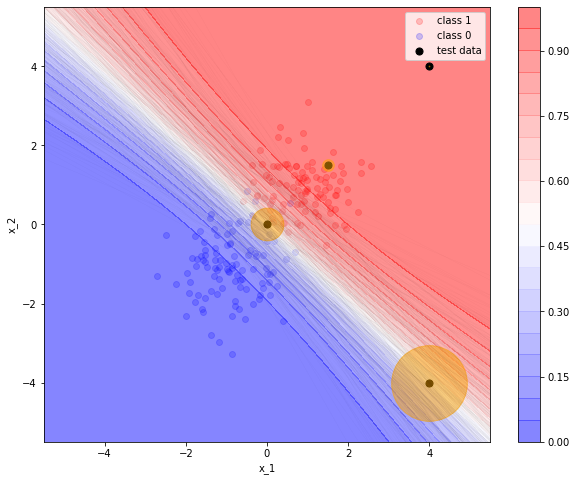

In [57]:
# plot the average decision boundaries from the 100 samples (posterior predictive)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)

for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
    

for test_point in test_points:
    test_pred_prob = np.zeros(100)
    test_point = np.array(test_point)
    # test_point = linear.fit_transform(test_point)
    
    for c,index in enumerate(posterior_samples_index):
        sample = samples[index]
        model = Bayesian_logistic_regression(sample[0], sample[1:])
        test_pred_prob[c] = model.predict_proba(test_point)[1]
        
    if c == 0:    
        ax.scatter(test_point[0], test_point[1], alpha=.5, s=100000/5*np.std(test_pred_prob), color='orange', label = 'ttt')
    else:
        ax.scatter(test_point[0], test_point[1], alpha=.5, s=100000/5*np.std(test_pred_prob), color='orange')
        
    print(f' estimated epistemic uncertainty of test point {test_point} (the std of the predict probability):{np.std(test_pred_prob)} \n the mean is {np.mean(test_pred_prob)}. the SEM is {scipy.stats.sem(test_pred_prob)}')
    
    
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

### Bayesian logistic regression with polynomial features

In [119]:
# train a logistic regression model on the data
poly_degree = 3

poly = PolynomialFeatures(poly_degree,include_bias=False)
x_poly = poly.fit_transform(x)
model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1);
model.fit(x_poly,y)

for c,test_point in enumerate(test_points):
    test_point = np.array(test_point).reshape(1,-1)
    test_point = poly.fit_transform(test_point)
    print(f' p({test_point} is class 0) = {(model.predict_proba(test_point.reshape(1,-1)))[0][0]} p({test_point} is class 1) = {(model.predict_proba(test_point.reshape(1,-1)))[0][1]}')
#     print(model.predict(test_point.reshape(1,-1)))

 p([[1.5   1.5   2.25  2.25  2.25  3.375 3.375 3.375 3.375]] is class 0) = 0.006425199032820128 p([[1.5   1.5   2.25  2.25  2.25  3.375 3.375 3.375 3.375]] is class 1) = 0.9935748009671799
 p([[0. 0. 0. 0. 0. 0. 0. 0. 0.]] is class 0) = 0.4947260506032707 p([[0. 0. 0. 0. 0. 0. 0. 0. 0.]] is class 1) = 0.5052739493967293
 p([[ 4.  4. 16. 16. 16. 64. 64. 64. 64.]] is class 0) = 0.0 p([[ 4.  4. 16. 16. 16. 64. 64. 64. 64.]] is class 1) = 1.0
 p([[  4.  -4.  16. -16.  16.  64. -64.  64. -64.]] is class 0) = 0.8486999189619743 p([[  4.  -4.  16. -16.  16.  64. -64.  64. -64.]] is class 1) = 0.15130008103802575


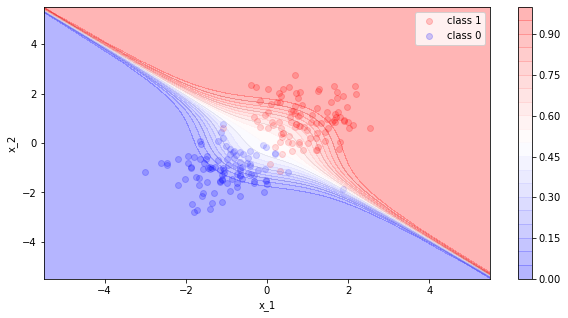

In [120]:
models = [model]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x[:,:], y, models, ax, poly_degree=poly_degree,shaded =True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [121]:
x_1 = np.append(np.ones([x_poly.shape[0],1]),x_poly,axis = 1) # add a column of ones
y = np.array([0] * 100 + [1] * 100)

### Setting up the energy functions for HMC
potential_energy = lambda q: np.sum(0.5*0.1 * np.power(q,2)) - np.dot(y,np.log(1e-10+ sigmoid(np.matmul(x_1,q))))- np.dot((1-y),np.log(1e-10+1 -sigmoid(np.matmul(x_1,q))))
kinetic_energy = lambda p: np.sum(0.5*np.power(p,2))
momentum_sampler = lambda n: np.random.normal(0,1,size = x_1.shape[1])

### Setting up hyperparameters of HMC
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = np.concatenate((model.intercept_, model.coef_.flatten()))
position_current = position_init.reshape(-1)
momentum_current = np.array([0.1, 0.1, 0.1])
step_size = 0.1
leapfrog_steps = 20

### Running HMC to sample from a target distribution
total_trials = 1500 # 5000
burn_in = 0.1
thin = 1
samples = [position_current]
accepts = 0.

for t in range(total_trials):
    position_current, momentum_current, accept = hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler)
    samples.append(position_current)
    accepts += accept
    if t % 100 == 0 and t > 0:
        print('{} iterations, accept rate: {}'.format(t, accepts / (t + 1.)))

accept_rate = accepts / total_trials
samples = np.array(samples[int(total_trials*burn_in)::thin])

100 iterations, accept rate: 0.9504950495049505
200 iterations, accept rate: 0.9601990049751243
300 iterations, accept rate: 0.9601328903654485
400 iterations, accept rate: 0.9650872817955112
500 iterations, accept rate: 0.9640718562874252
600 iterations, accept rate: 0.9683860232945092
700 iterations, accept rate: 0.9700427960057061
800 iterations, accept rate: 0.968789013732834
900 iterations, accept rate: 0.9678135405105438
1000 iterations, accept rate: 0.9660339660339661
1100 iterations, accept rate: 0.963669391462307
1200 iterations, accept rate: 0.9641965029142381
1300 iterations, accept rate: 0.9631053036126057
1400 iterations, accept rate: 0.961456102783726


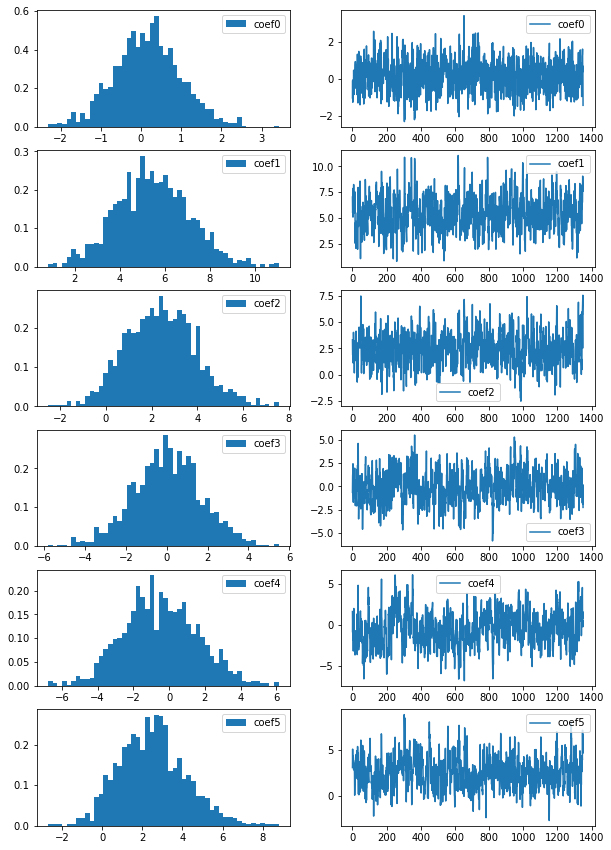

In [122]:
fig, ax = plt.subplots(6, 2, figsize=(10, 15))

for i in range(6):
    ax[i, 0].hist(samples[:, i], bins=50, density=True, label=f"coef{i}")
    ax[i, 1].plot(samples[:, i], label=f"coef{i}")

    ax[i, 0].legend()
    ax[i, 1].legend()


In [125]:
#Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Logistic Regression model (see In-Class Exercise 10.13)
# posterior_samples_index = np.random.choice(np.arange(len(samples)), size=500)
models = []

for index in posterior_samples_index:
    sample = samples[index]
    model = Bayesian_logistic_regression(sample[0], sample[1:])
    models.append(model)

/Users/zihealexzhang/anaconda3/envs/am207/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


 estimated epistemic uncertainty of test point (1.5, 1.5) (the std of the predict probability):6.195868489357853e-05 
 the mean is 0.9999911832582541. the SEM is 6.2270821301776095e-06
 estimated epistemic uncertainty of test point (0, 0) (the std of the predict probability):0.17580183274622607 
 the mean is 0.5386137247849756. the SEM is 0.017668748990183246
 estimated epistemic uncertainty of test point (4, 4) (the std of the predict probability):0.13578987302108153 
 the mean is 0.9806014466900129. the SEM is 0.01364739573154336
 estimated epistemic uncertainty of test point (4, -4) (the std of the predict probability):5.254740648224392e-14 
 the mean is 5.28121306084522e-15. the SEM is 5.281213060845219e-15


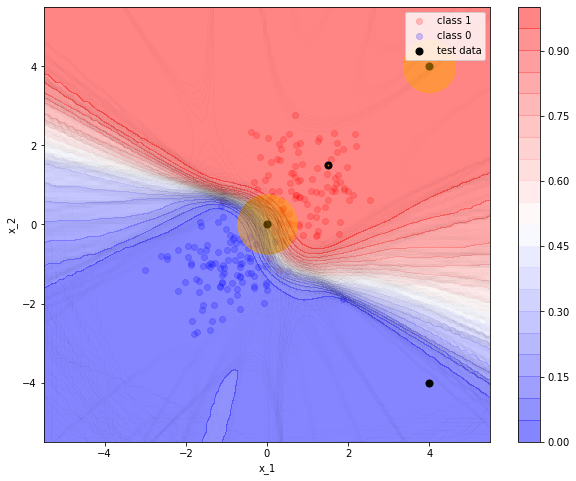

In [126]:
# Estimate the epistemic uncertainty of each test data point

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)

for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
    

for test_point in test_points:
    test_pred_prob = np.zeros(100)
    test_point_poly = poly.fit_transform(np.array(test_point).reshape(1,-1))
    for c,index in enumerate(posterior_samples_index):
        sample = samples[index]
        model = Bayesian_logistic_regression(sample[0], sample[1:])
#         print(model.predict_proba(test_point)[0][1])
        test_pred_prob[c] = model.predict_proba(test_point_poly)[0][1]
        
    if c == 0:    
        ax.scatter(test_point[0], test_point[1], alpha=.5, s=100000/5*np.std(test_pred_prob), color='orange', label = 'ttt')
    else:
        ax.scatter(test_point[0], test_point[1], alpha=.5, s=100000/5*np.std(test_pred_prob), color='orange')
        
    print(f' estimated epistemic uncertainty of test point {test_point} (the std of the predict probability):{np.std(test_pred_prob)} \n the mean is {np.mean(test_pred_prob)}. the SEM is {scipy.stats.sem(test_pred_prob)}')
    
    
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

## BBVI

In [116]:
model_MLE = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1);
model_MLE.fit(x_poly,y)

model = Bayesian_logistic_regression(model_MLE.intercept_,model_MLE.coef_.flatten())
D = model.D
weight_noise = 1**2
Sigma_W = weight_noise * np.eye(D)

paras = variational_inference(Sigma_W, y, x_poly, forward, S = 100, max_iteration=5000, step_size=1e-3, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -672.2636806756786; gradient mag: 252.94690791264574
Iteration 100 lower bound -628.2777047589444; gradient mag: 252.66308955529527
Iteration 200 lower bound -557.8686661290353; gradient mag: 247.74924326789878
Iteration 300 lower bound -485.86376464780017; gradient mag: 242.68093798382537
Iteration 400 lower bound -446.6483718011131; gradient mag: 239.99217378241948
Iteration 500 lower bound -379.7717884452361; gradient mag: 229.852929514572
Iteration 600 lower bound -329.44615964375396; gradient mag: 218.79039157226686
Iteration 700 lower bound -285.09810908710233; gradient mag: 211.78758382261347
Iteration 800 lower bound -240.95163982820446; gradient mag: 185.60421617710773
Iteration 900 lower bound -207.7552360381372; gradient mag: 165.3393191548056
Iteration 1000 lower bound -178.71920042605245; gradient mag: 126.01724304443505
Iteration 1100 lower bound -163.1383513991182; gradient mag: 99.96748014844121
Iteration 1200

In [117]:
# sample 1000 sets of W from the VI posterior

mean, log_std = paras[:D], paras[D:]
samples = np.random.randn(1000, D) * np.exp(log_std) + mean

# sample a 100 of those models

posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)

models = []
for index in posterior_samples_index:
    sample = np.array(samples[index])#.reshape(1,-1)
    model = Bayesian_logistic_regression(sample[0],sample[1:])
    models.append(model)

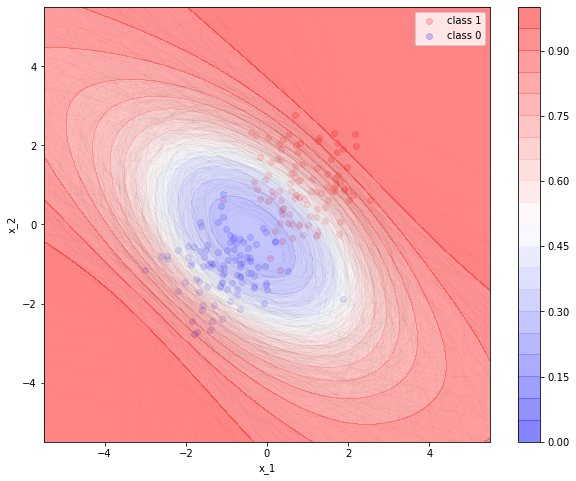

In [118]:
# plot the average decision boundaries from the 100 samples (posterior predictive)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)

### Bayesian neural network